# Data preprocessing

In [2]:
!pip install pywavelets

Defaulting to user installation because normal site-packages is not writeable


In [4]:
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications import EfficientNetB3
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pywt
import torch

2025-03-23 11:44:26.721134: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-23 11:44:26.883208: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742730266.959317  350322 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742730266.979471  350322 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-23 11:44:27.139664: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [5]:
def load_audio_files_cwt(directory, num_classes=6):
    files = os.listdir(directory)
    audios = []
    labels = []

    target_duration = 0.05  # 50ms
    sr = 22050
    target_freq_bins = 128
    target_time_steps = 1024

    for file in files:
        if file.endswith('.wav'):
            path = os.path.join(directory, file)

            # 다중 라벨 처리: [0, 1, 0, 0, 0, 0] 형식으로 변환
            label_index = int(file[:4])  # 예: 파일 이름의 앞 4자리

            # 오디오 로드
            audio, _ = librosa.load(path, sr=sr)

            # 길이 맞추기 (50ms 고정)
            target_length = int(target_duration * sr)
            if len(audio) < target_length:
                audio = np.pad(audio, (0, target_length - len(audio)), mode='constant')
            else:
                onset_frames = librosa.onset.onset_detect(y=audio, sr=sr, units="samples")
                onset_sample = onset_frames[0] if len(onset_frames) > 0 else 0
                end_sample = onset_sample + target_length
                audio = audio[onset_sample:end_sample]
                if len(audio) < target_length:
                    audio = np.pad(audio, (0, target_length - len(audio)), mode='constant')

            # Hamming 윈도우 적용
            audio *= np.hamming(len(audio))

            # CWT 변환 (1, freq_bins, time_steps)
            scales = np.arange(1, target_freq_bins + 1)
            cwt_matrix, _ = pywt.cwt(audio, scales, 'morl')
            cwt_magnitude = np.abs(cwt_matrix)  # (128, time)

            # 시간 축 조정 (pad or crop to 1024)
            time_len = cwt_magnitude.shape[1]
            if time_len < target_time_steps:
                pad_width = target_time_steps - time_len
                cwt_magnitude = np.pad(cwt_magnitude, ((0, 0), (0, pad_width)), mode='constant')
            else:
                cwt_magnitude = cwt_magnitude[:, :target_time_steps]

            # (1, 128, 1024)로 reshape
            cwt_tensor = torch.tensor(cwt_magnitude).unsqueeze(0).float()
            audios.append(cwt_tensor.numpy())
            labels.append(label_index)

    return audios, labels

In [6]:
# 폴더 "A"와 "B"에서 오디오 로드
audios, labels = load_audio_files_cwt('sliced')

/opt/conda/lib/python3.11/site-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1103
  warnings.warn(


In [7]:
audios[0].shape # (1, 127, 5512)

(1, 127, 1102)

In [8]:
len(audios)

38572

In [9]:
import numpy as np

# 라벨과 원-핫 인코딩 벡터 매핑 딕셔너리
label_to_multihot = {
    0: [0,0,0,0,0,0],
    1: [1,0,0,0,0,0],
    2: [0,1,0,0,0,0],
    6: [0,0,0,1,0,0],
    8: [0,0,0,0,1,0],
    11: [0,0,0,0,0,1],
    12: [0,0,1,0,0,0],
    106: [1,0,0,1,0,0],
    108: [1,0,0,0,1,0],
    111: [1,0,0,0,0,1],
    206: [0,1,0,1,0,0],
    208: [0,1,0,0,1,0],
    211: [0,1,0,0,0,1],
    608: [0,0,0,1,1,0],
    611: [0,0,0,1,0,1],
    612: [0,0,1,1,0,0],
    811: [0,0,0,0,1,1],
    812: [0,0,1,0,1,0],
    1112: [0,0,1,0,0,1],
}

# 원-핫 인코딩 변환 함수
def convert_to_multihot(labels, label_to_onehot):
    multihot_encoded = np.array([label_to_multihot[label] for label in labels])
    return multihot_encoded

# 라벨 변환
labels_multihot = convert_to_multihot(labels, label_to_multihot)
# labels_multihot_test = convert_to_multihot(labels_test, label_to_multihot)

In [10]:
labels_multihot

array([[1, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 1],
       [0, 0, 1, 1, 0, 0],
       ...,
       [0, 1, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0]])

In [11]:
import numpy as np
from collections import defaultdict

# 다중 라벨 데이터를 균형 있게 샘플링하는 함수
def balanced_sampling(X, y, sample_size=50, random_state=42):
    np.random.seed(random_state)
    
    # 라벨을 문자열로 변환하여 그룹화 (mutable 자료형인 리스트는 직접 비교 불가하기 때문)
    label_dict = defaultdict(list)
    
    for idx, label in enumerate(y):
        label_str = str(label.tolist())  # 리스트를 문자열로 변환하여 key로 사용
        label_dict[label_str].append(idx)
    
    train_indices = []
    test_indices = []
    
    for label_str, indices in label_dict.items():
        np.random.shuffle(indices)  # 랜덤하게 섞기
        
        test_sample = indices[:50]  # 테스트 세트: 50개 고정
        train_sample = indices[50:]  # 나머지는 훈련 세트
        
        test_indices.extend(test_sample)
        train_indices.extend(train_sample)
        
        print(f"Label: {label_str}, Train: {len(train_sample)}, Test: {len(test_sample)}")
    
    # 최종 선택된 데이터 추출
    X_train, X_test = X[train_indices], X[test_indices]
    y_train, y_test = y[train_indices], y[test_indices]
    
    return X_train, X_test, y_train, y_test

X = np.array(audios)  # 리스트 -> NumPy 배열 변환
y = np.array(labels_multihot)  # 리스트 -> NumPy 배열 변환

# 데이터셋 분할 실행
X_train, X_test, y_train, y_test = balanced_sampling(X, y)

Label: [1, 0, 0, 1, 0, 0], Train: 1950, Test: 50
Label: [1, 0, 0, 0, 0, 1], Train: 1950, Test: 50
Label: [0, 0, 1, 1, 0, 0], Train: 1950, Test: 50
Label: [0, 0, 0, 1, 1, 0], Train: 1950, Test: 50
Label: [0, 0, 1, 0, 0, 0], Train: 2287, Test: 50
Label: [1, 0, 0, 0, 0, 0], Train: 1950, Test: 50
Label: [0, 1, 0, 1, 0, 0], Train: 1950, Test: 50
Label: [0, 1, 0, 0, 0, 0], Train: 1950, Test: 50
Label: [0, 1, 0, 0, 1, 0], Train: 1950, Test: 50
Label: [0, 0, 0, 0, 0, 1], Train: 1950, Test: 50
Label: [0, 0, 0, 0, 0, 0], Train: 1950, Test: 50
Label: [0, 0, 0, 0, 1, 1], Train: 1950, Test: 50
Label: [1, 0, 0, 0, 1, 0], Train: 1950, Test: 50
Label: [0, 0, 1, 0, 1, 0], Train: 1950, Test: 50
Label: [0, 0, 1, 0, 0, 1], Train: 1950, Test: 50
Label: [0, 0, 0, 1, 0, 0], Train: 1950, Test: 50
Label: [0, 0, 0, 1, 0, 1], Train: 1950, Test: 50
Label: [0, 1, 0, 0, 0, 1], Train: 1950, Test: 50
Label: [0, 0, 0, 0, 1, 0], Train: 2185, Test: 50


# training

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision.transforms as transforms
from tqdm import tqdm
import copy

cuda


In [13]:
import torch
import torch.nn as nn
import torchvision.models as models

class ResNet101Classifier(nn.Module):
    def __init__(self, num_classes):
        super(ResNet101Classifier, self).__init__()

        # Pretrained ResNet101 모델 불러오기
        self.backbone = models.resnet101(pretrained=True)

        # 입력 채널이 1이면 첫 conv layer 수정
        self.backbone.conv1 = nn.Conv2d(
            1, 64, kernel_size=7, stride=2, padding=3, bias=False
        )

        # 마지막 fc layer 교체
        self.backbone.fc = nn.Linear(self.backbone.fc.in_features, num_classes)

    def forward(self, x):
        return self.backbone(x)

In [14]:
import torch
from torch.utils.data import Dataset
import numpy as np

# 커스텀 데이터셋 클래스 정의
class AudioDataset(Dataset):
    def __init__(self, audios, labels, max_time_dim=None, transform=None):
        self.audios = audios
        self.labels = labels
        self.max_time_dim = max_time_dim or max([audio.shape[-1] for audio in audios])  # 최대 시간 축 크기 찾기
        self.transform = transform

    def __len__(self):
        return len(self.audios)

    def __getitem__(self, idx):
        sample = self.audios[idx]  # NumPy 배열로 된 오디오 데이터를 로드
        label = self.labels[idx]

        # NumPy 배열을 텐서로 변환
        sample = torch.tensor(sample).float()  # [1, 1026, N] 형식

        # 시간 축을 기준으로 패딩 적용하여 최대 시간 길이에 맞춤
        time_padding = self.max_time_dim - sample.shape[-1]
        if time_padding > 0:
            sample = torch.nn.functional.pad(sample, (0, time_padding), mode='constant', value=0)

        if self.transform:
            sample = self.transform(sample)

        return sample, label

# 데이터 증강 및 전처리 변환 설정 (이미 텐서로 변환되었으므로 ToTensor()는 불필요)
train_transform = None
test_transform = None

# PyTorch Dataset 생성
train_dataset = AudioDataset(X_train, y_train, transform=train_transform)
test_dataset = AudioDataset(X_test, y_test, transform=test_transform)

# DataLoader 설정
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

sample, label = train_dataset[0]
sample_size = sample.size()

sample_size

torch.Size([1, 127, 1102])

In [15]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader
from tqdm import tqdm
import copy
import os
import matplotlib.pyplot as plt

# 모델, 옵티마이저, 학습 기록 저장 함수
def save_checkpoint(epoch, model, optimizer, history, best_val_accuracy, filename="checkpoint.pth"):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'history': history,
        'best_val_accuracy': best_val_accuracy
    }
    torch.save(checkpoint, filename)
    print(f"Checkpoint saved at epoch {epoch+1}")

# 저장된 체크포인트 불러오기
def load_checkpoint(filename, model, optimizer):
    if os.path.isfile(filename):
        checkpoint = torch.load(filename)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch = checkpoint['epoch']
        history = checkpoint['history']
        best_val_accuracy = checkpoint['best_val_accuracy']
        print(f"Checkpoint loaded from epoch {epoch+1}")
        return epoch, history, best_val_accuracy
    else:
        print("No checkpoint found.")
        return 0, {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}, 0.0

# 학습 기록 그래프 출력 함수
def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    
    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss History')
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy History')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [16]:
def evaluate(model, loader, classification_criterion):
    model.eval()
    running_loss = 0.0
    correct_per_sample = 0  
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device).float()

            class_output_logits = model(inputs)
            classification_loss = classification_criterion(class_output_logits, labels)
            running_loss += classification_loss.item()

            # Sigmoid 적용 후 이진화
            class_output = torch.sigmoid(class_output_logits)
            preds = (class_output > 0.5).int()

            # 샘플 단위 정확도
            correct_per_sample += (preds == labels).all(dim=1).sum().item()
            total_samples += labels.shape[0]  

    accuracy = correct_per_sample / total_samples
    return running_loss / len(loader), accuracy

In [17]:
def train_and_evaluate(model, train_loader, test_loader, optimizer, num_epochs, device, scheduler, checkpoint_file='checkpoint.pth'):
    start_epoch, history, best_val_accuracy = load_checkpoint(checkpoint_file, model, optimizer)
    best_model_wts = copy.deepcopy(model.state_dict())

    classification_criterion = nn.BCEWithLogitsLoss()

    for epoch in range(start_epoch, num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        print(f"Epoch [{epoch+1}/{num_epochs}] training...")

        for inputs, labels in tqdm(train_loader, desc="Training", leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device).float()

            optimizer.zero_grad()
            class_output_logits = model(inputs)
            classification_loss = classification_criterion(class_output_logits, labels)

            loss = classification_loss
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

            predicted = (torch.sigmoid(class_output_logits) > 0.5).int()
            correct += (predicted == labels).all(dim=1).sum().item()
            total += labels.shape[0]

        train_loss = running_loss / len(train_loader)
        train_accuracy = correct / total

        print("Evaluating on validation set...")
        val_loss, val_accuracy = evaluate(model, test_loader, classification_criterion)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Loss: {train_loss:.4f}, Acc: {train_accuracy:.4f}, "
              f"Val_Loss: {val_loss:.4f}, Val_Acc: {val_accuracy:.4f}")

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_accuracy)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_accuracy)

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())
            print(f"🔥 New best model with val_accuracy: {val_accuracy:.4f} 🔥")

        save_checkpoint(epoch, model, optimizer, history, best_val_accuracy, checkpoint_file)

        # best 모델 저장
        model.load_state_dict(best_model_wts)
        torch.save(model.state_dict(), 'best_model.pth')

        scheduler.step()
        print(f"Updated Learning Rate: {scheduler.get_last_lr()[0]:.6f}")

    return model, history

In [19]:
from torch.optim.lr_scheduler import StepLR

# 학습 실행
num_epochs = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 모델, 옵티마이저 설정
model = ResNet101Classifier(num_classes=len(label_to_multihot[0]))
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 학습률 스케줄러 추가
scheduler = StepLR(optimizer, step_size=5, gamma=0.9)

filename = "checkpoint_0322_v3_resnet101/checkpoint.pth"

# 학습 및 평가 시작
trained_model, history = train_and_evaluate(model, train_loader, test_loader, optimizer, num_epochs, device, scheduler, filename)

/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


No checkpoint found.
Epoch [1/20] training...


Evaluating on validation set...
Epoch [1/20], Loss: 0.2925, Acc: 0.4734, Val_Loss: 0.2270, Val_Acc: 0.5989
🔥 New best model with val_accuracy: 0.5989 🔥
Checkpoint saved at epoch 1
Updated Learning Rate: 0.000100
Epoch [2/20] training...


Evaluating on validation set...
Epoch [2/20], Loss: 0.2274, Acc: 0.5930, Val_Loss: 0.2193, Val_Acc: 0.6000
🔥 New best model with val_accuracy: 0.6000 🔥
Checkpoint saved at epoch 2
Updated Learning Rate: 0.000100
Epoch [3/20] training...


Evaluating on validation set...
Epoch [3/20], Loss: 0.1925, Acc: 0.6534, Val_Loss: 0.1793, Val_Acc: 0.6684
🔥 New best model with val_accuracy: 0.6684 🔥
Checkpoint saved at epoch 3
Updated Learning Rate: 0.000100
Epoch [4/20] training...


Evaluating on validation set...
Epoch [4/20], Loss: 0.1651, Acc: 0.7035, Val_Loss: 0.1692, Val_Acc: 0.6989
🔥 New best model with val_accuracy: 0.6989 🔥
Checkpoint saved at epoch 4
Updated Learning Rate: 0.000100
Epoch [5/20] training...


Evaluating on validation set...
Epoch [5/20], Loss: 0.1385, Acc: 0.7521, Val_Loss: 0.1748, Val_Acc: 0.6937
Checkpoint saved at epoch 5
Updated Learning Rate: 0.000090
Epoch [6/20] training...


Evaluating on validation set...
Epoch [6/20], Loss: 0.1308, Acc: 0.7657, Val_Loss: 0.1726, Val_Acc: 0.7000
🔥 New best model with val_accuracy: 0.7000 🔥
Checkpoint saved at epoch 6
Updated Learning Rate: 0.000090
Epoch [7/20] training...


Evaluating on validation set...
Epoch [7/20], Loss: 0.1038, Acc: 0.8106, Val_Loss: 0.1663, Val_Acc: 0.7295
🔥 New best model with val_accuracy: 0.7295 🔥
Checkpoint saved at epoch 7
Updated Learning Rate: 0.000090
Epoch [8/20] training...


Evaluating on validation set...
Epoch [8/20], Loss: 0.0783, Acc: 0.8585, Val_Loss: 0.1845, Val_Acc: 0.7305
🔥 New best model with val_accuracy: 0.7305 🔥
Checkpoint saved at epoch 8
Updated Learning Rate: 0.000090
Epoch [9/20] training...


Evaluating on validation set...
Epoch [9/20], Loss: 0.0603, Acc: 0.8919, Val_Loss: 0.1793, Val_Acc: 0.7568
🔥 New best model with val_accuracy: 0.7568 🔥
Checkpoint saved at epoch 9
Updated Learning Rate: 0.000090
Epoch [10/20] training...


Evaluating on validation set...
Epoch [10/20], Loss: 0.0496, Acc: 0.9111, Val_Loss: 0.1883, Val_Acc: 0.7274
Checkpoint saved at epoch 10
Updated Learning Rate: 0.000081
Epoch [11/20] training...


Evaluating on validation set...
Epoch [11/20], Loss: 0.0421, Acc: 0.9259, Val_Loss: 0.1995, Val_Acc: 0.7189
Checkpoint saved at epoch 11
Updated Learning Rate: 0.000081
Epoch [12/20] training...


Evaluating on validation set...
Epoch [12/20], Loss: 0.0437, Acc: 0.9240, Val_Loss: 0.1978, Val_Acc: 0.7179
Checkpoint saved at epoch 12
Updated Learning Rate: 0.000081
Epoch [13/20] training...


Evaluating on validation set...
Epoch [13/20], Loss: 0.0425, Acc: 0.9244, Val_Loss: 0.1885, Val_Acc: 0.7389
Checkpoint saved at epoch 13
Updated Learning Rate: 0.000081
Epoch [14/20] training...


Evaluating on validation set...
Epoch [14/20], Loss: 0.0438, Acc: 0.9236, Val_Loss: 0.2018, Val_Acc: 0.7200
Checkpoint saved at epoch 14
Updated Learning Rate: 0.000081
Epoch [15/20] training...


Evaluating on validation set...
Epoch [15/20], Loss: 0.0435, Acc: 0.9235, Val_Loss: 0.2030, Val_Acc: 0.7316
Checkpoint saved at epoch 15
Updated Learning Rate: 0.000073
Epoch [16/20] training...


Evaluating on validation set...
Epoch [16/20], Loss: 0.0371, Acc: 0.9341, Val_Loss: 0.2112, Val_Acc: 0.7347
Checkpoint saved at epoch 16
Updated Learning Rate: 0.000073
Epoch [17/20] training...


Evaluating on validation set...
Epoch [17/20], Loss: 0.0402, Acc: 0.9302, Val_Loss: 0.2023, Val_Acc: 0.7305
Checkpoint saved at epoch 17
Updated Learning Rate: 0.000073
Epoch [18/20] training...


Evaluating on validation set...
Epoch [18/20], Loss: 0.0395, Acc: 0.9301, Val_Loss: 0.1826, Val_Acc: 0.7368
Checkpoint saved at epoch 18
Updated Learning Rate: 0.000073
Epoch [19/20] training...


Evaluating on validation set...
Epoch [19/20], Loss: 0.0388, Acc: 0.9320, Val_Loss: 0.1933, Val_Acc: 0.7368
Checkpoint saved at epoch 19
Updated Learning Rate: 0.000073
Epoch [20/20] training...


Evaluating on validation set...
Epoch [20/20], Loss: 0.0398, Acc: 0.9302, Val_Loss: 0.1992, Val_Acc: 0.7326
Checkpoint saved at epoch 20
Updated Learning Rate: 0.000066


In [20]:
from torch.optim.lr_scheduler import StepLR

# 학습 실행
num_epochs = 20+40
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 모델, 옵티마이저 설정
model = ResNet101Classifier(num_classes=len(label_to_multihot[0]))
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 학습률 스케줄러 추가
# scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.8, patience=3, min_lr=0.000001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.95)

filename = "checkpoint_0322_v3_resnet101/checkpoint.pth"

# 학습 및 평가 시작
trained_model, history = train_and_evaluate(model, train_loader, test_loader, optimizer, num_epochs, device, scheduler, filename)

/tmp/ipykernel_350322/1285455833.py:24: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename)


Checkpoint loaded from epoch 20
Epoch [20/60] training...


Evaluating on validation set...
Epoch [20/60], Loss: 0.0306, Acc: 0.9467, Val_Loss: 0.1981, Val_Acc: 0.7442
Checkpoint saved at epoch 20
Updated Learning Rate: 0.000073
Epoch [21/60] training...


Evaluating on validation set...
Epoch [21/60], Loss: 0.0307, Acc: 0.9471, Val_Loss: 0.2139, Val_Acc: 0.7358
Checkpoint saved at epoch 21
Updated Learning Rate: 0.000073
Epoch [22/60] training...


Evaluating on validation set...
Epoch [22/60], Loss: 0.0311, Acc: 0.9458, Val_Loss: 0.2208, Val_Acc: 0.7316
Checkpoint saved at epoch 22
Updated Learning Rate: 0.000073
Epoch [23/60] training...


Evaluating on validation set...
Epoch [23/60], Loss: 0.0306, Acc: 0.9472, Val_Loss: 0.2330, Val_Acc: 0.7221
Checkpoint saved at epoch 23
Updated Learning Rate: 0.000073
Epoch [24/60] training...


Evaluating on validation set...
Epoch [24/60], Loss: 0.0308, Acc: 0.9462, Val_Loss: 0.2262, Val_Acc: 0.7084
Checkpoint saved at epoch 24
Updated Learning Rate: 0.000069
Epoch [25/60] training...


Evaluating on validation set...
Epoch [25/60], Loss: 0.0295, Acc: 0.9490, Val_Loss: 0.2090, Val_Acc: 0.7484
Checkpoint saved at epoch 25
Updated Learning Rate: 0.000069
Epoch [26/60] training...


Evaluating on validation set...
Epoch [26/60], Loss: 0.0296, Acc: 0.9491, Val_Loss: 0.2282, Val_Acc: 0.7411
Checkpoint saved at epoch 26
Updated Learning Rate: 0.000069
Epoch [27/60] training...


Evaluating on validation set...
Epoch [27/60], Loss: 0.0298, Acc: 0.9491, Val_Loss: 0.2292, Val_Acc: 0.7347
Checkpoint saved at epoch 27
Updated Learning Rate: 0.000069
Epoch [28/60] training...


Evaluating on validation set...
Epoch [28/60], Loss: 0.0304, Acc: 0.9485, Val_Loss: 0.1932, Val_Acc: 0.7421
Checkpoint saved at epoch 28
Updated Learning Rate: 0.000069
Epoch [29/60] training...


Evaluating on validation set...
Epoch [29/60], Loss: 0.0290, Acc: 0.9507, Val_Loss: 0.2286, Val_Acc: 0.7389
Checkpoint saved at epoch 29
Updated Learning Rate: 0.000066
Epoch [30/60] training...


Evaluating on validation set...
Epoch [30/60], Loss: 0.0283, Acc: 0.9512, Val_Loss: 0.1948, Val_Acc: 0.7537
Checkpoint saved at epoch 30
Updated Learning Rate: 0.000066
Epoch [31/60] training...


Evaluating on validation set...
Epoch [31/60], Loss: 0.0275, Acc: 0.9534, Val_Loss: 0.2072, Val_Acc: 0.7421
Checkpoint saved at epoch 31
Updated Learning Rate: 0.000066
Epoch [32/60] training...


Evaluating on validation set...
Epoch [32/60], Loss: 0.0283, Acc: 0.9514, Val_Loss: 0.2299, Val_Acc: 0.7432
Checkpoint saved at epoch 32
Updated Learning Rate: 0.000066
Epoch [33/60] training...


Evaluating on validation set...
Epoch [33/60], Loss: 0.0286, Acc: 0.9521, Val_Loss: 0.2099, Val_Acc: 0.7411
Checkpoint saved at epoch 33
Updated Learning Rate: 0.000066
Epoch [34/60] training...


Evaluating on validation set...
Epoch [34/60], Loss: 0.0280, Acc: 0.9531, Val_Loss: 0.2034, Val_Acc: 0.7463
Checkpoint saved at epoch 34
Updated Learning Rate: 0.000063
Epoch [35/60] training...


Evaluating on validation set...
Epoch [35/60], Loss: 0.0267, Acc: 0.9551, Val_Loss: 0.2301, Val_Acc: 0.7358
Checkpoint saved at epoch 35
Updated Learning Rate: 0.000063
Epoch [36/60] training...


Evaluating on validation set...
Epoch [36/60], Loss: 0.0268, Acc: 0.9549, Val_Loss: 0.2057, Val_Acc: 0.7495
Checkpoint saved at epoch 36
Updated Learning Rate: 0.000063
Epoch [37/60] training...


Evaluating on validation set...
Epoch [37/60], Loss: 0.0276, Acc: 0.9534, Val_Loss: 0.2071, Val_Acc: 0.7295
Checkpoint saved at epoch 37
Updated Learning Rate: 0.000063
Epoch [38/60] training...


Evaluating on validation set...
Epoch [38/60], Loss: 0.0263, Acc: 0.9555, Val_Loss: 0.1945, Val_Acc: 0.7337
Checkpoint saved at epoch 38
Updated Learning Rate: 0.000063
Epoch [39/60] training...


Evaluating on validation set...
Epoch [39/60], Loss: 0.0271, Acc: 0.9538, Val_Loss: 0.2384, Val_Acc: 0.7263
Checkpoint saved at epoch 39
Updated Learning Rate: 0.000059
Epoch [40/60] training...


Evaluating on validation set...
Epoch [40/60], Loss: 0.0249, Acc: 0.9577, Val_Loss: 0.2228, Val_Acc: 0.7442
Checkpoint saved at epoch 40
Updated Learning Rate: 0.000059
Epoch [41/60] training...


Evaluating on validation set...
Epoch [41/60], Loss: 0.0260, Acc: 0.9551, Val_Loss: 0.2157, Val_Acc: 0.7463
Checkpoint saved at epoch 41
Updated Learning Rate: 0.000059
Epoch [42/60] training...


Evaluating on validation set...
Epoch [42/60], Loss: 0.0256, Acc: 0.9572, Val_Loss: 0.1944, Val_Acc: 0.7474
Checkpoint saved at epoch 42
Updated Learning Rate: 0.000059
Epoch [43/60] training...


Evaluating on validation set...
Epoch [43/60], Loss: 0.0252, Acc: 0.9588, Val_Loss: 0.2150, Val_Acc: 0.7368
Checkpoint saved at epoch 43
Updated Learning Rate: 0.000059
Epoch [44/60] training...


Evaluating on validation set...
Epoch [44/60], Loss: 0.0257, Acc: 0.9581, Val_Loss: 0.2236, Val_Acc: 0.7232
Checkpoint saved at epoch 44
Updated Learning Rate: 0.000056
Epoch [45/60] training...


Evaluating on validation set...
Epoch [45/60], Loss: 0.0246, Acc: 0.9599, Val_Loss: 0.2371, Val_Acc: 0.7263
Checkpoint saved at epoch 45
Updated Learning Rate: 0.000056
Epoch [46/60] training...


Evaluating on validation set...
Epoch [46/60], Loss: 0.0244, Acc: 0.9595, Val_Loss: 0.2006, Val_Acc: 0.7579
🔥 New best model with val_accuracy: 0.7579 🔥
Checkpoint saved at epoch 46
Updated Learning Rate: 0.000056
Epoch [47/60] training...


Evaluating on validation set...
Epoch [47/60], Loss: 0.0191, Acc: 0.9695, Val_Loss: 0.2277, Val_Acc: 0.7421
Checkpoint saved at epoch 47
Updated Learning Rate: 0.000056
Epoch [48/60] training...


Evaluating on validation set...
Epoch [48/60], Loss: 0.0190, Acc: 0.9688, Val_Loss: 0.2130, Val_Acc: 0.7474
Checkpoint saved at epoch 48
Updated Learning Rate: 0.000056
Epoch [49/60] training...


Evaluating on validation set...
Epoch [49/60], Loss: 0.0192, Acc: 0.9686, Val_Loss: 0.2110, Val_Acc: 0.7484
Checkpoint saved at epoch 49
Updated Learning Rate: 0.000054
Epoch [50/60] training...


Evaluating on validation set...
Epoch [50/60], Loss: 0.0171, Acc: 0.9727, Val_Loss: 0.2530, Val_Acc: 0.7189
Checkpoint saved at epoch 50
Updated Learning Rate: 0.000054
Epoch [51/60] training...


Evaluating on validation set...
Epoch [51/60], Loss: 0.0188, Acc: 0.9705, Val_Loss: 0.2132, Val_Acc: 0.7632
🔥 New best model with val_accuracy: 0.7632 🔥
Checkpoint saved at epoch 51
Updated Learning Rate: 0.000054
Epoch [52/60] training...


Evaluating on validation set...
Epoch [52/60], Loss: 0.0157, Acc: 0.9750, Val_Loss: 0.2312, Val_Acc: 0.7337
Checkpoint saved at epoch 52
Updated Learning Rate: 0.000054
Epoch [53/60] training...


Evaluating on validation set...
Epoch [53/60], Loss: 0.0171, Acc: 0.9714, Val_Loss: 0.2177, Val_Acc: 0.7484
Checkpoint saved at epoch 53
Updated Learning Rate: 0.000054
Epoch [54/60] training...


Evaluating on validation set...
Epoch [54/60], Loss: 0.0146, Acc: 0.9772, Val_Loss: 0.2266, Val_Acc: 0.7474
Checkpoint saved at epoch 54
Updated Learning Rate: 0.000051
Epoch [55/60] training...


Evaluating on validation set...
Epoch [55/60], Loss: 0.0145, Acc: 0.9779, Val_Loss: 0.2536, Val_Acc: 0.7389
Checkpoint saved at epoch 55
Updated Learning Rate: 0.000051
Epoch [56/60] training...


Evaluating on validation set...
Epoch [56/60], Loss: 0.0152, Acc: 0.9767, Val_Loss: 0.2163, Val_Acc: 0.7421
Checkpoint saved at epoch 56
Updated Learning Rate: 0.000051
Epoch [57/60] training...


Evaluating on validation set...
Epoch [57/60], Loss: 0.0152, Acc: 0.9762, Val_Loss: 0.2436, Val_Acc: 0.7189
Checkpoint saved at epoch 57
Updated Learning Rate: 0.000051
Epoch [58/60] training...


Evaluating on validation set...
Epoch [58/60], Loss: 0.0148, Acc: 0.9773, Val_Loss: 0.2120, Val_Acc: 0.7368
Checkpoint saved at epoch 58
Updated Learning Rate: 0.000051
Epoch [59/60] training...


Evaluating on validation set...
Epoch [59/60], Loss: 0.0151, Acc: 0.9768, Val_Loss: 0.2267, Val_Acc: 0.7474
Checkpoint saved at epoch 59
Updated Learning Rate: 0.000048
Epoch [60/60] training...


Evaluating on validation set...
Epoch [60/60], Loss: 0.0145, Acc: 0.9771, Val_Loss: 0.2193, Val_Acc: 0.7537
Checkpoint saved at epoch 60
Updated Learning Rate: 0.000048


# result - best val_accuracy: 0.7632

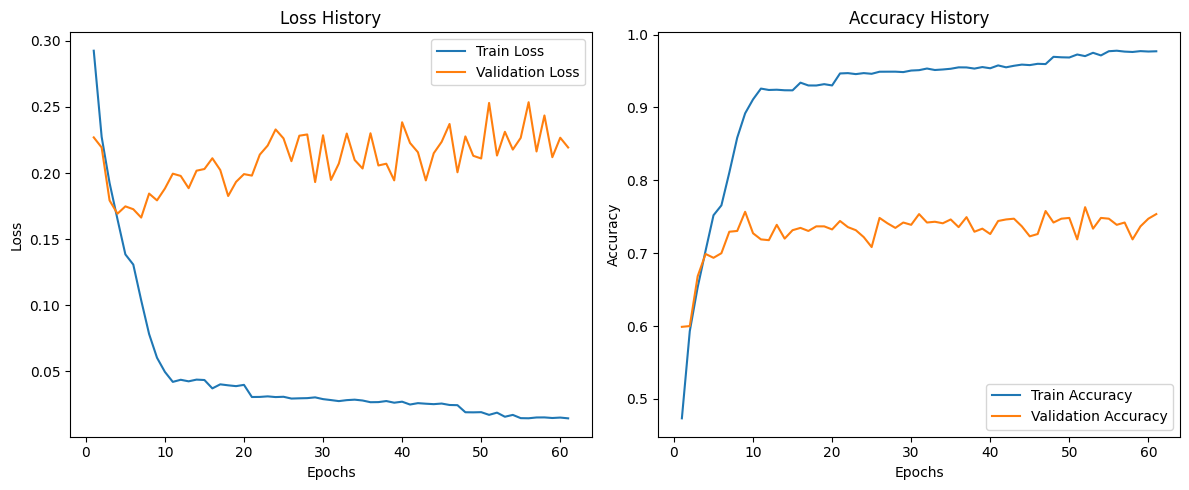

In [21]:
plot_history(history)